In [1]:
import os
import pandas as pd
import numpy as np 
import pingouin as pg 
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
def Get_participants(folder_dir) : 
    
    participants = os.listdir(folder_dir)
    participants = sorted([ x.split(sep=".")[0] for x in participants if x.endswith(".csv") and not x.startswith(".")])
    

    return participants

def Partis_Dict(folder_dir) : 

    participants = Get_participants( folder_dir )

    participants_dict = { x : None for x  in participants} 
    
    for parti in participants_dict:
        arr = np.loadtxt( folder_dir + "/" + parti + ".csv", delimiter=",", dtype=float)
        
        participants_dict[parti] = arr
    
    return participants_dict

def Dict2Arr( dict_ ) : 
    arr = []
    for key in dict_ :
        arr.append(dict_[key])
    
    return np.array(arr)

def cvt_Zero2AVG_range( arr , avg_range= 5 ): 
        
    zero_index = np.argwhere(arr==0)

    for index in zero_index :
        row, col = index 

        if row >= avg_range and row + avg_range <= len(arr): 
                arr[row, col] = arr[row-avg_range:row+avg_range, col].mean()
            
    return arr 

def cvt_Zer2AVG(arr):

    avg = arr.mean()
    arr = np.where(arr==0, avg, arr)

    return arr 
    


def get_avg_data( arr, avg_range = 2, converting = 2 ) :
    
    if converting == 1 :
        arr = cvt_Zer2AVG(arr)
        
    elif converting == 2 :
        arr = cvt_Zero2AVG_range(arr,avg_range)
    
    return arr.mean(axis=0)
    
    
    

In [3]:
curr_dir = os.getcwd() + "/Eye_track"

right_iris_dir = curr_dir + "/LeftIrisDiameterInMM"
left_iris_dir = curr_dir + "/RightIrisDiameterInMM"

right_pupil_dir = curr_dir + "/RightPupilDiameterInMM"
left_pupil_dir = curr_dir + "/LeftPupilDiameterInMM"


right_iris = Partis_Dict(right_iris_dir)
left_iris = Partis_Dict(left_iris_dir)

right_pupil = Partis_Dict(right_pupil_dir)
left_pupil = Partis_Dict(left_pupil_dir)

print("Dict_type 데이터")
print("-"*50)

len(right_iris)
len(left_iris)
len(right_pupil)
len(left_pupil)

print(right_iris[next(iter(right_iris))].shape)
print(left_iris[next(iter(right_iris))].shape)
print(right_pupil[next(iter(right_iris))].shape)
print(left_pupil[next(iter(right_iris))].shape)

print("\nArray_type 변환 후")
print("-"*50)

right_iris = Dict2Arr(right_iris)
left_iris = Dict2Arr(left_iris)
right_pupil = Dict2Arr(right_pupil)
left_pupil = Dict2Arr(left_pupil)

print(right_iris.shape)
print(left_iris.shape)
print(right_pupil.shape)
print(left_pupil.shape)

Dict_type 데이터
--------------------------------------------------
(11950, 16)
(11950, 16)
(11950, 16)
(11950, 16)

Array_type 변환 후
--------------------------------------------------
(52, 11950, 16)
(52, 11950, 16)
(52, 11950, 16)
(52, 11950, 16)


In [4]:
# Convert Iris diameter to Iris thickness

left_iris = (left_iris - left_pupil ) / 2
right_iris = (right_iris - right_pupil) / 2 

# left_pupil = left_pupil / 2
# right_pupil = right_pupil / 2

In [5]:
eyes_list = [right_iris, left_iris, right_pupil, left_pupil]

In [6]:
avg_data = [ ] #  [right_iris, left_iris, right_pupil, left_pupil] 순서

for eye_data in eyes_list : 

    participant_arr = []

    for participant in range(len(eye_data)) :  # (Participants, Frame_num, Vidoe_num)
        
        participant_arr.append(get_avg_data(eye_data[participant],converting=2)) # (Frame_num, Vidoe_num)

    avg_data.append(np.array(participant_arr))  # (Participants ,Video_num)

avg_data = np.array(avg_data) 
avg_data.shape # ( 데이터 개수, 참가자 수, 영상 수)


(4, 52, 16)

In [7]:
eyes = [ "right_iris", "left_iris", "right_pupil", "left_pupil"]

for ind, eye in enumerate(avg_data) :
    print(eyes[ind])
    print("-"*100)

    data = eye.reshape(-1,4).mean(axis=1).flatten()
    blocks = [ "HMHB", "HMLB", "LMHB", "LMLB"] * len(eye)
    names = np.repeat(np.arange(len(eye)),4)

    df = pd.DataFrame( { 'names' : names, 'rating' : data, 'blocks': blocks})

    results = pg.rm_anova( data= df, dv='rating', within='blocks', subject='names', correction=True)
    print(results[['ddof1','F','p-unc']])


    post_hoc = pg.pairwise_tests(data= df, dv='rating', within='blocks', subject='names', padjust='bonf')
    print("-"*100,'\n')
    print(post_hoc[['A','B','T','p-unc']].round(4))
    print("="*100,'\n') 



right_iris
----------------------------------------------------------------------------------------------------
   ddof1           F         p-unc
0      3  137.259575  3.459696e-43
---------------------------------------------------------------------------------------------------- 

      A     B        T   p-unc
0  HMHB  HMLB  14.3391  0.0000
1  HMHB  LMHB   4.3200  0.0001
2  HMHB  LMLB  15.6212  0.0000
3  HMLB  LMHB  -9.9533  0.0000
4  HMLB  LMLB   4.1520  0.0001
5  LMHB  LMLB  14.5069  0.0000

left_iris
----------------------------------------------------------------------------------------------------
   ddof1           F         p-unc
0      3  130.573871  5.463037e-42
---------------------------------------------------------------------------------------------------- 

      A     B        T   p-unc
0  HMHB  HMLB  13.6808  0.0000
1  HMHB  LMHB   4.4528  0.0000
2  HMHB  LMLB  16.2948  0.0000
3  HMLB  LMHB  -9.6723  0.0000
4  HMLB  LMLB   3.5999  0.0007
5  LMHB  LMLB  12.8066  0.0

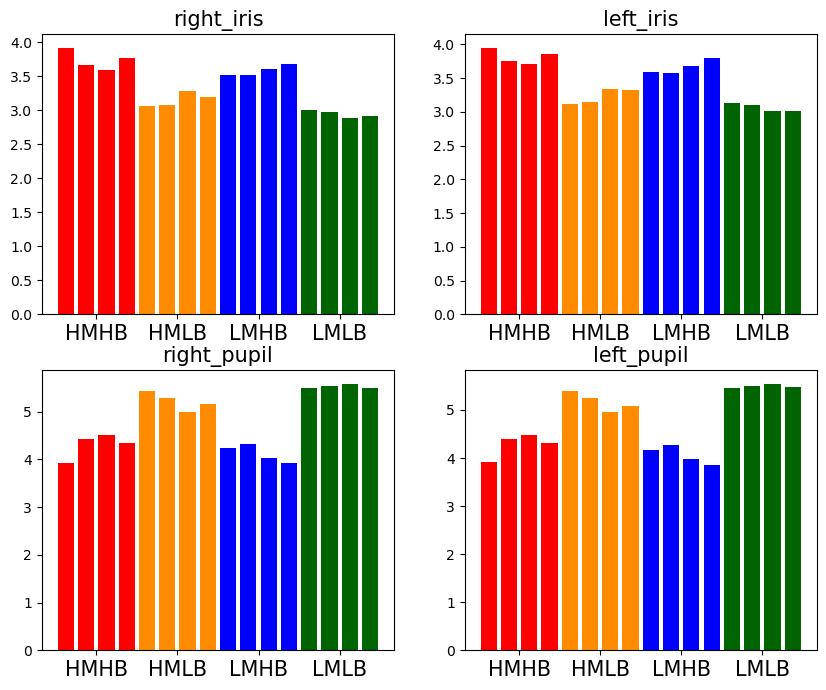

In [8]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,8)

axs = axs.ravel()

eyes = [ 'right_iris', 'left_iris', 'right_pupil', 'left_pupil']
colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']

for ind, ax in enumerate(axs) : 
    ax.bar(range(16), avg_data[ind].mean(axis=0), color = np.repeat(colors,4))
    ax.set_xticks( [ 1.5, 5.5, 9.5, 13.5], block_names, fontsize = 15); 
    ax.set_title(eyes[ind], fontsize = 15)

[0.12, 0.09, 0.07, 0.04]
[0.09, 0.1, 0.09, 0.06]
[0.23, 0.16, 0.16, 0.04]
[0.21, 0.17, 0.16, 0.04]


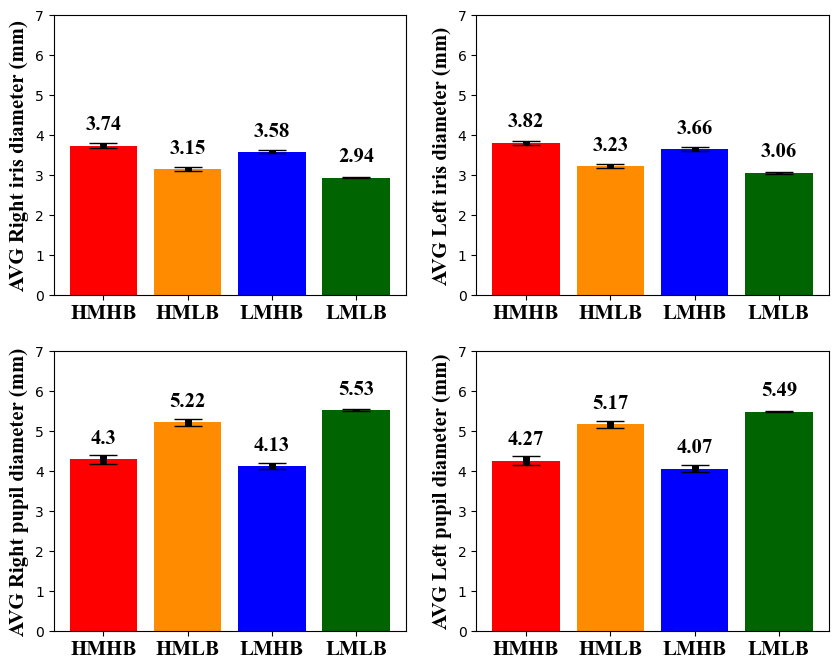

In [9]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,8)

def singnificantLine(ax, x1, x2, y, text, font_size = 15, ha_ = 'center',family_ = 'Times New Roman', weight_ ='bold' ):
    ax.hlines(y, x1, x2, colors='gray', linestyles='solid')
    ax.vlines(x1, y, y-(x2-x1)/ 10, colors='gray', linestyles='solid')
    ax.vlines(x2, y, y-(x2-x1)/ 10, colors='gray', linestyles='solid')
    ax.text( (x1+x2)/2, y, text, fontsize = font_size, ha = ha_,family = family_, weight=weight_)

font_dict = {'family': 'Times New Roman',
      'color':  'black',
      'weight': 'bold',
      'size': 15,
      'va' : 'center',
      'ha' : 'center' }

axs = axs.ravel()

eyes = [ 'AVG Right iris diameter (mm)', 'AVG Left iris diameter (mm)', 'AVG Right pupil diameter (mm)', 'AVG Left pupil diameter (mm)']
colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']
ylim = [ 7, 7, 7, 7 ]
adding = [ 0.5,0.5,0.5,0.5] * 4

for ind, ax in enumerate(axs): 
    datas = avg_data[ind].mean(axis=0).reshape(-1,4).mean(axis=1)
    se = [ np.std(avg_data[ind].mean(axis=0)[x:x+4]) / np.sqrt(4) for x in range(0,16,4)]

    ax.bar(range(4), datas, color = colors)
    ax.set_xticks( range(4), block_names, fontsize = 15, family = "Times New Roman", weight = "bold") ;
    ax.set_ylabel(eyes[ind], fontsize = 15, family = "Times New Roman", weight = "bold"); 
    ax.set_ylim(0,ylim[ind])
    ax.errorbar(range(4), datas, yerr = se , linestyle = 'None',capsize=10, capthick=1,elinewidth=5, color='black'); 


    #ax.set_title(eyes[ind], fontsize = 15)
    print([np.std(avg_data[ind].mean(axis=0)[x:x+4]).round(2) for x in range(0,16,4)])
    for ind_, data in enumerate(datas) :
        ax.text(ind_, data + adding[ind], data.round(2), ha ="center", fontdict=font_dict )

In [10]:
sampling_rate = 100
video_len = 120 
window_size = 30

window_eyes_arr = [ ]

for eye_data in eyes_list : 
    
    eyes_arr = []

    for participant in range(len(eye_data)):

        data = eye_data[participant]
        participant_arr = []

        for index in range(video_len-window_size +1) : 
            
            if index*sampling_rate + window_size*sampling_rate <= len(data) : 
                arr = data[index*sampling_rate : index*sampling_rate + window_size*sampling_rate]
                
            else : 
                arr = data[index*sampling_rate : len(data)]

            participant_arr.append(arr.mean(axis=0)) # (window_num, video_num)

        eyes_arr.append(participant_arr) # (participants, window_num, video_num)

    window_eyes_arr.append(eyes_arr)

window_eyes_arr = np.array(window_eyes_arr)
window_eyes_arr.shape #  ( 데이터 개수 ,participants, window_num, video_num)


(4, 52, 91, 16)

In [20]:
right_pupil_windows = window_eyes_arr[2, ...]
left_pupil_windows = window_eyes_arr[3, ...]


save_dir = os.getcwd() + "/Window_data/Right_pupil"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for ind, participant in enumerate(right_pupil_windows) :
    np.savetxt(save_dir + f"/{ind}.csv", participant, delimiter = ",")

save_dir = os.getcwd() + "/Window_data/Left_pupil"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for ind, participant in enumerate(left_pupil_windows) :
    np.savetxt(save_dir + f"/{ind}.csv", participant, delimiter = ",")

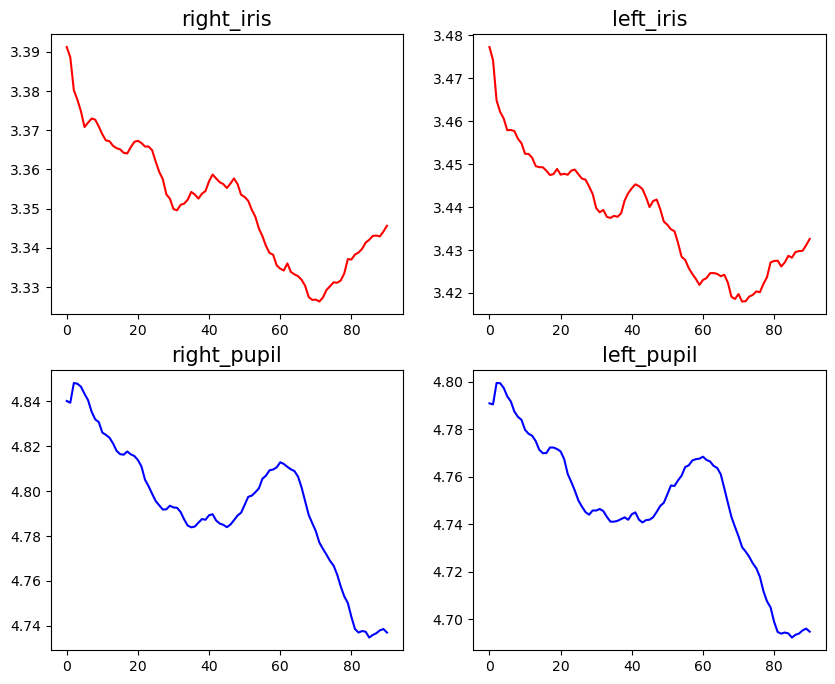

In [11]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,8)

axs = axs.ravel()

eyes = [ 'right_iris', 'left_iris', 'right_pupil', 'left_pupil']
colors = ['r', 'r', 'b', 'b']
block_names = ['HMHB','HMLB','LMHB','LMLB']

for ind, ax in enumerate(axs) : 
    ax.plot(range(window_eyes_arr.shape[2]), window_eyes_arr[ind].mean(axis=(0,2)), color=colors[ind])
    ax.set_title(eyes[ind], fontsize = 15)

In [12]:
block_data = []
for index in range(len(window_eyes_arr)) :
    block = np.array([window_eyes_arr[index].mean(axis=0)[:,x:x+4].mean(axis=1) for x in range(0,16,4)])
    block_data.append(block)
block_data = np.array(block_data)

block_data.shape

(4, 4, 91)

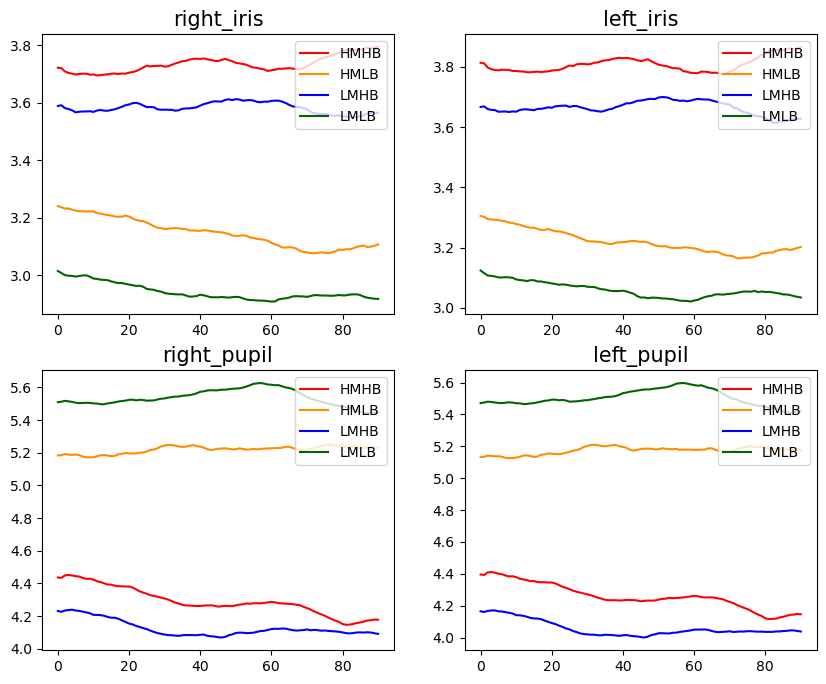

In [13]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,8)

axs = axs.ravel()

eyes = [ 'right_iris', 'left_iris', 'right_pupil', 'left_pupil']
colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']

for ind, ax in enumerate(axs) : 

    for block_ind in range(len(eyes)) : 
        ax.plot(range(window_eyes_arr.shape[2]), block_data[ind][block_ind], color=colors[block_ind])
    ax.set_title(eyes[ind], fontsize = 15)
    ax.legend(block_names, loc =1)

In [14]:
window_eyes_arr.shape


(4, 52, 91, 16)

In [15]:
high_low = []

for eye in window_eyes_arr : 
    high = eye.mean(axis=0)[:,[0,1,2,3,8,9,10,11]].mean(axis=1)
    low = eye.mean(axis=0)[:,[4,5,6,7,12,13,14,15]].mean(axis=1)
    high_low.append([high, low])

high_low = np.array(high_low)
high_low.shape

(4, 2, 91)

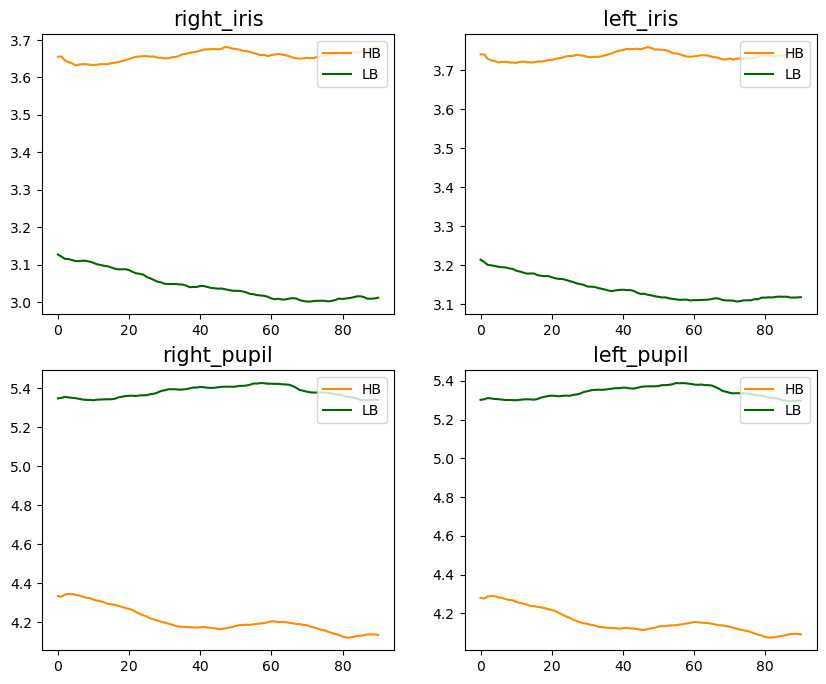

In [16]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,8)

axs = axs.ravel()

eyes = [ 'right_iris', 'left_iris', 'right_pupil', 'left_pupil']
colors = ['darkorange','darkgreen']
block_names = ["HB", "LB"]

for ind, ax in enumerate(axs) : 

    for block_ind in range(high_low.shape[1]) : 
        ax.plot(range(high_low.shape[2]), high_low[ind][block_ind], color=colors[block_ind])
    ax.set_title(eyes[ind], fontsize = 15)
    ax.legend(block_names, loc =1)

In [17]:
eyes = [ 'right_iris', 'left_iris', 'right_pupil', 'left_pupil']
AVG_dir = os.getcwd() + "/AVG"

if not os.path.isdir(AVG_dir):
    os.mkdir(AVG_dir)

iris = (avg_data[0] + avg_data[1]) / 2 
pupil = (avg_data[2] + avg_data[3]) / 2 

for ind, eye in enumerate(avg_data) :
    df = pd.DataFrame(eye)
    df.to_csv(AVG_dir + f"/{eyes[ind]}.csv")
